In [9]:
import sys
sys.path.insert(0, '/home/workspace/mm_analysis')
sys.path.insert(0, '/home/workspace/')

from py_util import *
from utilities import *

hdir = '/home/workspace/'
wdir = hdir + "/mm_analysis/EXP-01244"
pltdir = wdir + "/plots/"
srldir = wdir + "/objects/"

raw_adata = sc.read_h5ad(srldir + 'raw_adata.h5ad')
adata = sc.read_h5ad(srldir + 'processed_adata_allcells.h5ad')

/home/workspace/mm_analysis/README.md
/home/workspace/mm_analysis/.ipynb_checkpoints
/home/workspace/mm_analysis/r_env.sh
/home/workspace/mm_analysis/py_env.sh
/home/workspace/mm_analysis/_utils_corrected.py
/home/workspace/mm_analysis/py_util.py
/home/workspace/mm_analysis/r_util.r
/home/workspace/mm_analysis/bm_cell_label_reference.csv
/home/workspace/mm_analysis/.git
/home/workspace/mm_analysis/__pycache__
/home/workspace/mm_analysis/EXP-01244
/home/workspace/mm_analysis/.gitignore


# Generating and processing batched adata without downsmapling

In [5]:
def process_adata(adata):
    
    # Filtering out mitochondrial and Ig genes
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ig"] = adata.var_names.str.contains("^IG")
    
    adata = adata[:, (adata.var['mt'] == False) & (adata.var['ig'] == False)]

    # Applying scanpy processing pipeline
    sc.pp.calculate_qc_metrics(
        adata, 
        qc_vars=["mt", "ig"],
        inplace=True,
        log1p=True
    )

    adata.layers["counts"] = adata.X.copy()
    sc.pp.normalize_total(adata)
    sc.pp.log1p(adata)

    sc.pp.highly_variable_genes(
        adata, 
        n_top_genes=2000, 
        batch_key="sample"
    )
    sc.tl.pca(adata)

    X = adata.obsm['X_pca'].astype(np.float64)

    harmony_out = hm.run_harmony(X, adata.obs, 'sample_type')

    adata.obsm['X_pca'] = harmony_out.Z_corr.T

    sc.pp.neighbors(adata)
    sc.tl.draw_graph(adata)
    sc.tl.umap(adata)

    res_range = np.round(np.arange(0, 2.2, 0.2), 1)
    
    for res in res_range:
        sc.tl.leiden(
            adata, 
            flavor="igraph",
            key_added=f"leiden_{str(res).replace('.', '_')}",
            n_iterations=2,
            resolution=res
        )
    
    # sc.tl.paga(adata, groups='leiden')
    # sc.tl.rank_genes_groups(
    #     adata, 
    #     groupby="leiden", 
    #     method="wilcoxon"
    # )

    # sc.tl.diffmap(adata)

    return adata


adata = process_adata(raw_adata).copy()

adata.write(srldir + 'processed_adata_allcells.h5ad', compression='gzip')

2025-01-24 18:31:54,219 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-01-24 18:31:58,971 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-01-24 18:31:59,195 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-01-24 18:32:10,684 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-01-24 18:32:21,767 - harmonypy - INFO - Converged after 2 iterations
Converged after 2 iterations
/home/workspace/environment/tissdiss_py_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# UMAPs

In [47]:
def subplot_grids(n, subplot_size=10, orientation='horizontal', **kwargs):
   if orientation == 'horizontal':
       cols = int(np.ceil(np.sqrt(n)))
       rows = int(np.ceil(n / cols))
   else:
       rows = int(np.ceil(np.sqrt(n)))
       cols = int(np.ceil(n / rows))
   
   kwargs.pop('figsize', None)
   figsize = (cols * subplot_size, rows * subplot_size)
   
   fig, axes = plt.subplots(rows, cols, figsize=figsize, **kwargs)
   
   axes_flat = axes.flatten()
   for i in range(n, len(axes_flat)):
       fig.delaxes(axes_flat[i])
       
   indices = list(np.ndindex(axes.shape))
   
   return fig, axes, indices

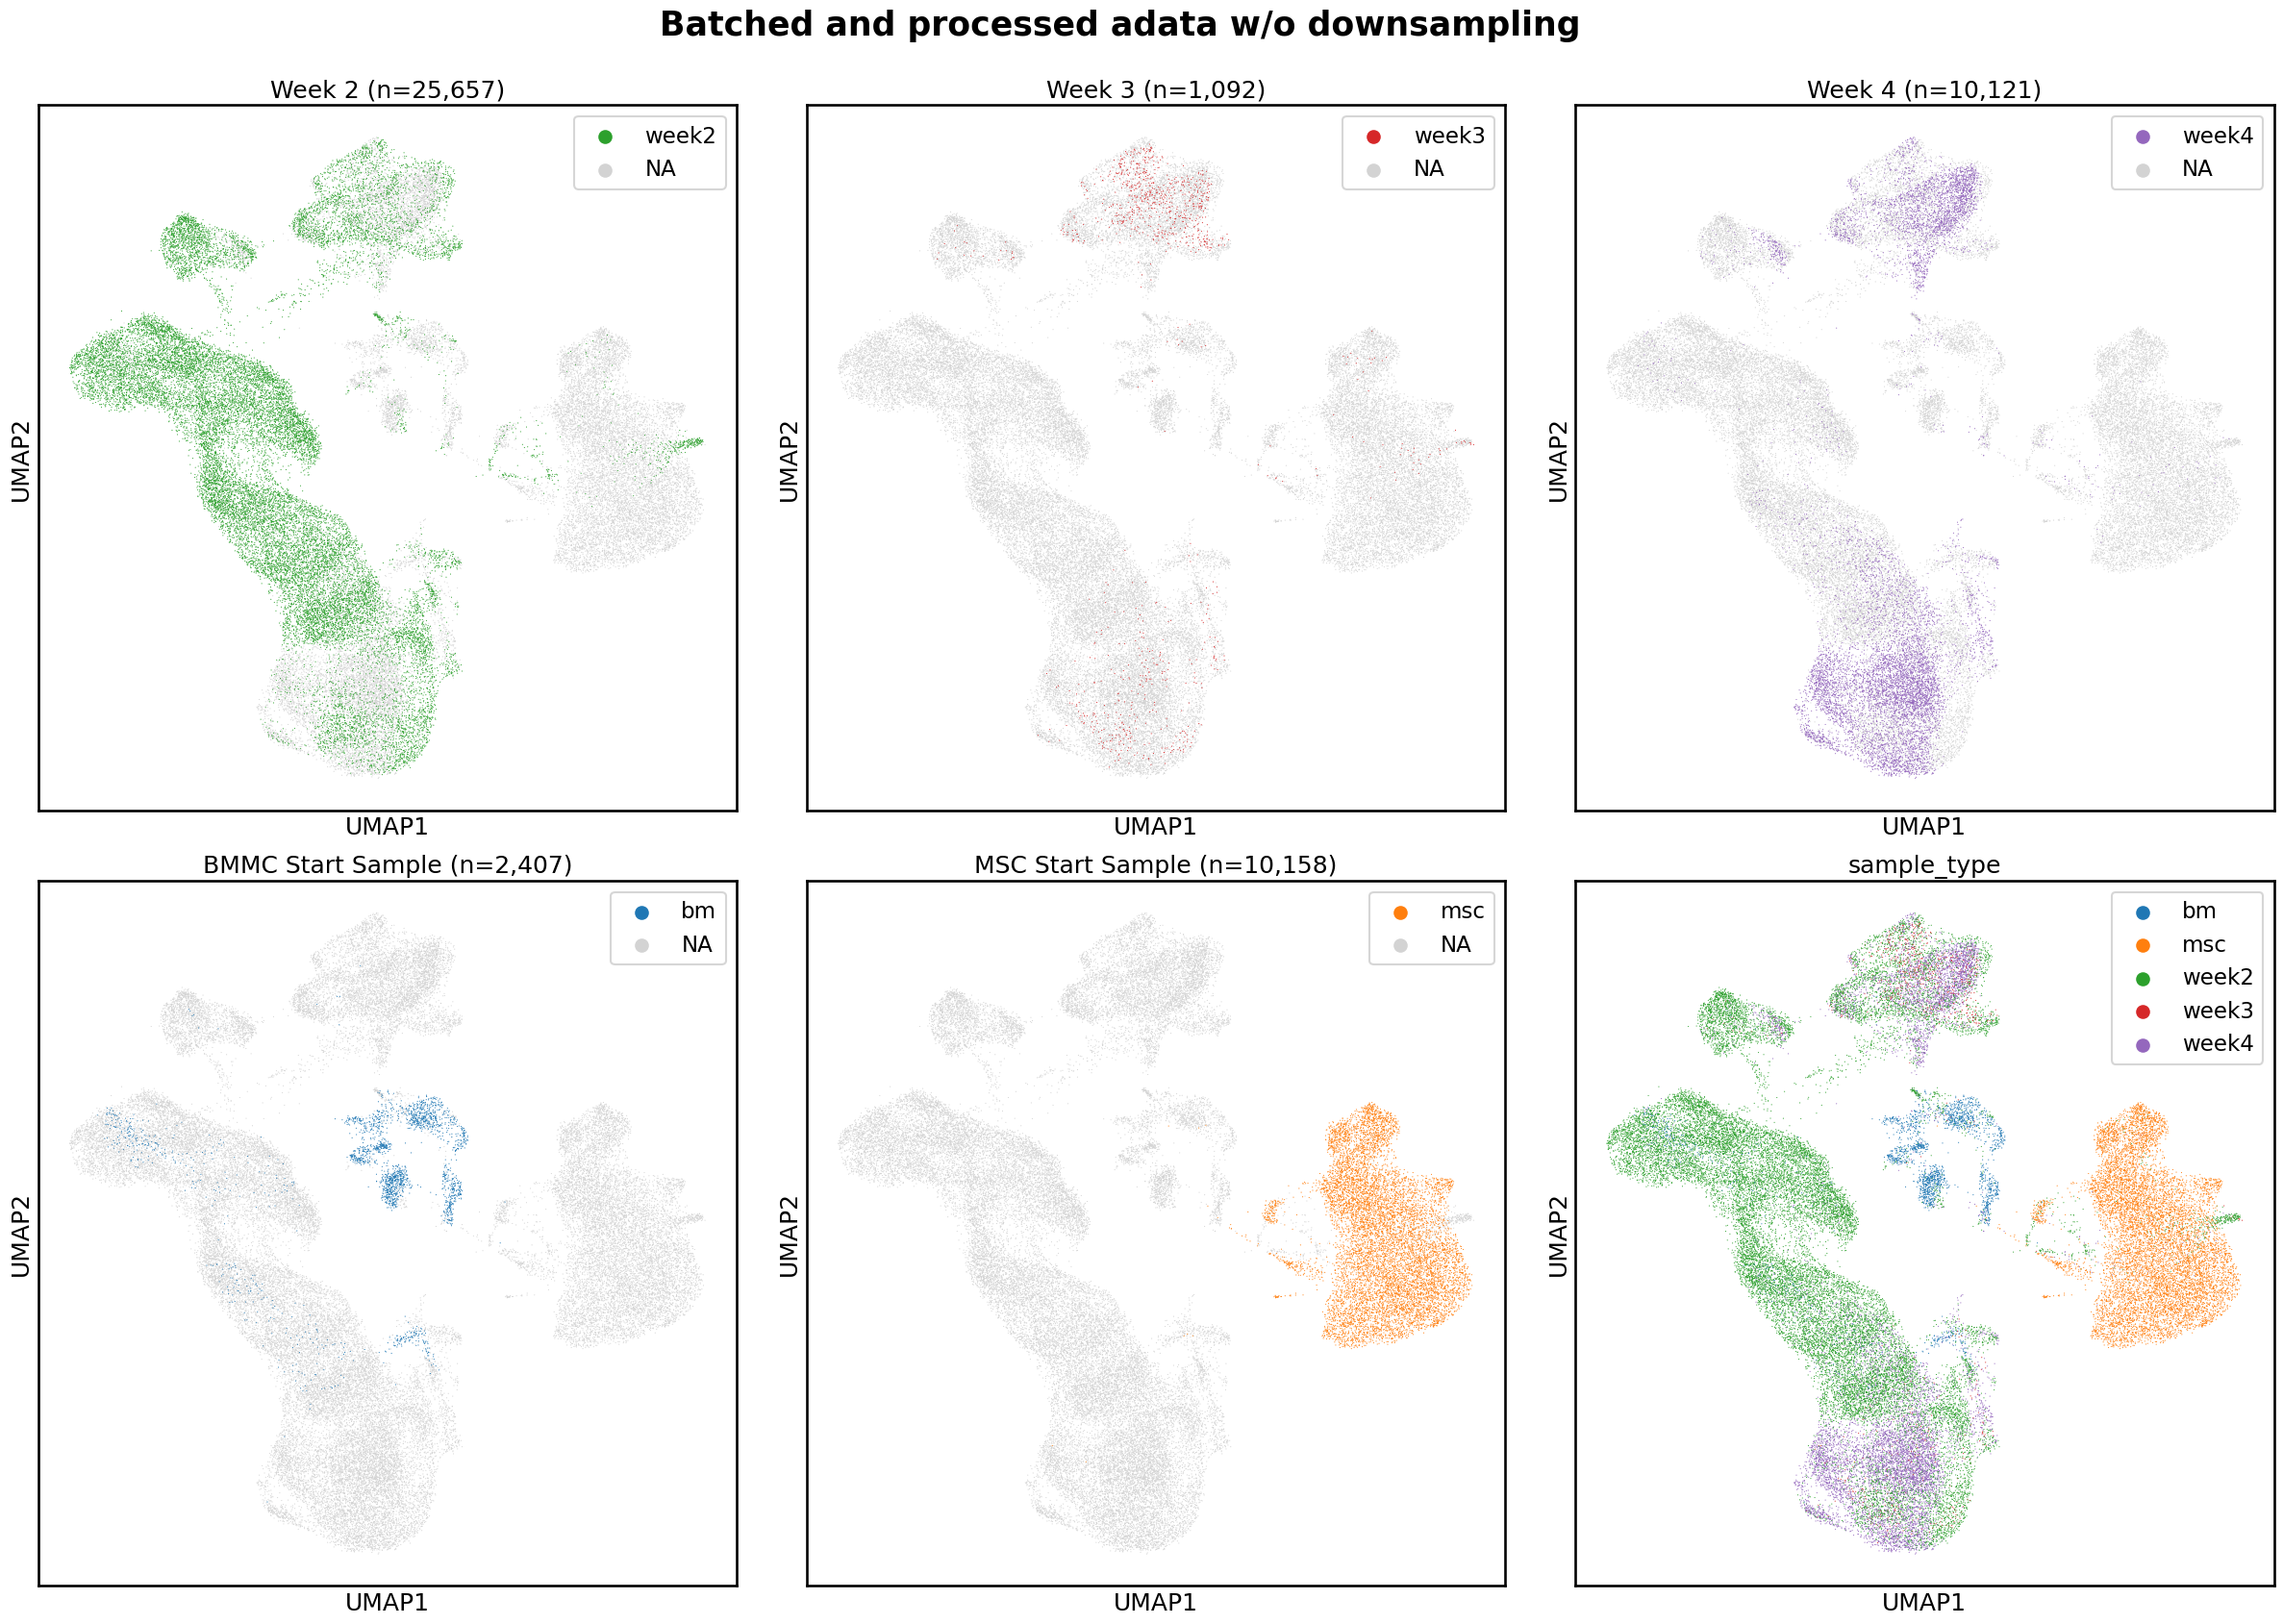

In [13]:
types = ['week2', 'week3', 'week4', 'bm', 'msc']

fig, ax, indices = subplot_grids(len(types) + 1, subplot_size=10, gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i, sample_type in zip(indices, types):
    cell_num = len(adata[adata.obs['sample_type'] == sample_type])
    label = adata[adata.obs['sample_type'] == sample_type].obs['names'].unique()[0]
    sc.pl.umap(
        adata,
        color='sample_type',
        groups=sample_type,
        title=f'{label} (n={cell_num:,})',
        show=False,
        ax=ax[i],
        legend_loc='best'
    )

sc.pl.umap(adata, color='sample_type', show=False, ax=ax[1,2], legend_loc='best')

fig.suptitle('Batched and processed adata w/o downsampling', fontsize=25, y=0.93, weight='bold')

fig.savefig(pltdir + f'sample_UMAPs_allcells/batched_sample_UMAPs_allcells_overlayed.pdf', bbox_inches='tight', dpi=300)

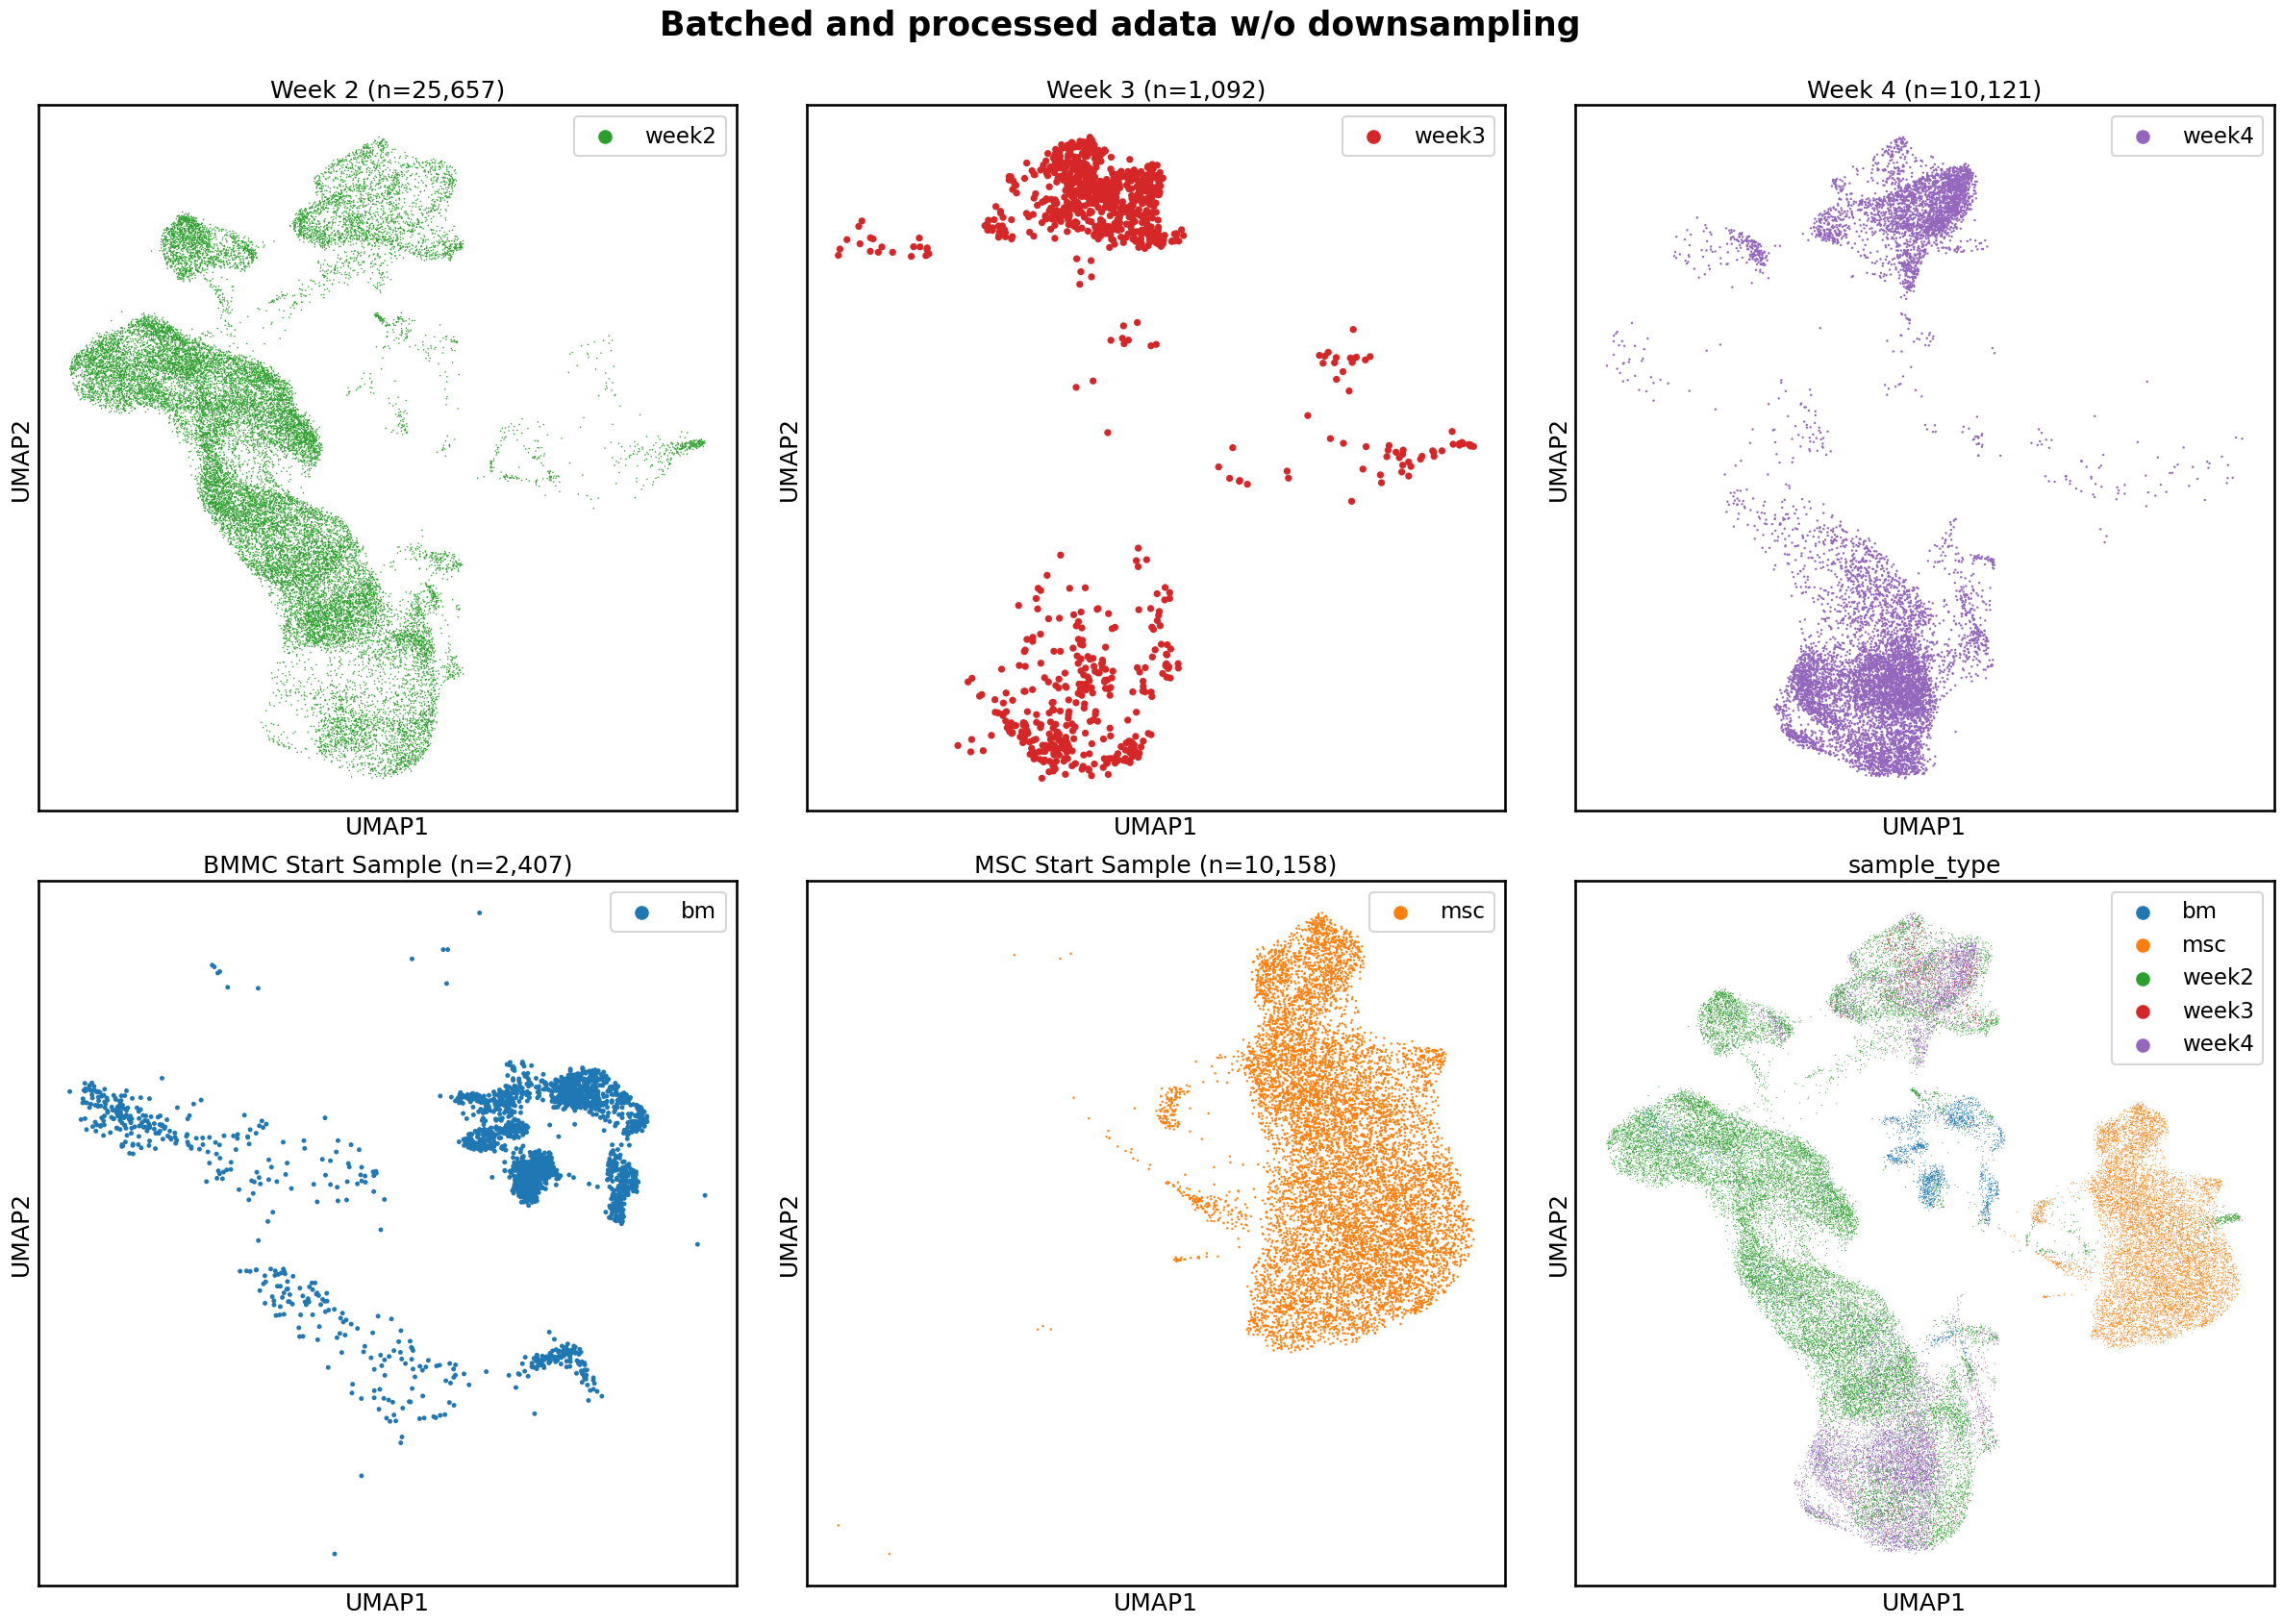

In [14]:
types = ['week2', 'week3', 'week4', 'bm', 'msc']

fig, ax, indices = subplot_grids(len(types) + 1, subplot_size=10, gridspec_kw={'wspace': 0.1, 'hspace': 0.1})

for i, sample_type in zip(indices, types):
    mask = adata.obs['sample_type'] == sample_type
    cell_num = len(adata[adata.obs['sample_type'] == sample_type])
    label = adata[adata.obs['sample_type'] == sample_type].obs['names'].unique()[0]
    sc.pl.umap(
        adata[mask],
        color='sample_type',
        title=f'{label} (n={cell_num:,})',
        show=False,
        ax=ax[i],
        legend_loc='best'
    )

sc.pl.umap(adata, color='sample_type', show=False, ax=ax[1,2], legend_loc='best')

fig.suptitle('Batched and processed adata w/o downsampling', fontsize=25, y=0.93, weight='bold')

fig.savefig(pltdir + f'sample_UMAPs_allcells/batched_sample_UMAPs_allcells_individual.pdf', bbox_inches='tight', dpi=300)